In [1]:
import gym
import numpy as np
import tensorflow as tf
import keras
# from keras.optimizers import Adam
from keras.models import load_model
# from utlis import plotLearning

2022-03-08 05:40:52.501755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jayanths/.mujoco/mujoco210/bin
2022-03-08 05:40:52.501871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# store (s,a,r,s') pairs in a buffer such that they can be used for training the neural network
# Specify the buffer size and the dimenision of the input while defining the buffer
class ReplyBuffer():
    def __init__(self, mem_size, input_dims):
        self.mem_size = mem_size
        self.mem_cntr = 0  #points to the starting point of the ReplyBuffer
        self.state_memory = np.zeros((self.mem_size,*input_dims),dtype = np.float32) 
        #if input_dims is a list then *input_dims will unpack the list (advantage is it can be expandable)
        
        self.new_state_memory = np.zeros((self.mem_size,*input_dims),dtype = np.float32) 
        self.action_memory = np.zeros(self.mem_size, dtype = np.int32)
        
        self.reward_memory = np.zeros(self.mem_size, dtype = np.int32)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.int32) #to keep track of episodes that end with a win
        
    # define a function that stores (s,a,r,s') in the buffer
    def store_transition(self,state,action,reward,new_state,done):
        index = self.mem_cntr%self.mem_size # tells where the (s,a,r,s') pair has to be stored
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = int(done) #why (1-done) ?  
        self.mem_cntr += 1
     
    # define a function that samples a set of (s,a,r,s') pairs so that it can be fed to NN for training 
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)  #to avoid sampling just zeros
        batch = np.random.choice(max_mem, batch_size, replace = False) 
        
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        termination = self.terminal_memory[batch]
        
        return states, actions, rewards, new_states, termination
        
        
def build_dqn(lr,n_actions, input_dims, fc1_dims, fc2_dims):
    model = keras.Sequential([
        keras.layers.Dense(fc1_dims, activation = 'relu'),
        keras.layers.Dense(fc2_dims, activation = 'relu'),
        keras.layers.Dense(n_actions, activation = None)])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = 'mse')
    
    return model
        
    
class Agent():
    def __init__(self,lr,n_actions,gamma,epsilon,batch_size,
                input_dims, epsilon_dec = 1e-4, epsilon_end = 0.01,
                mem_size = 100000, fname = 'dqn_model.h5', alpha = 0.2):
        self.action = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.decrease_epsilon = epsilon_dec
        self.memory = ReplyBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(lr, n_actions, input_dims,128, 128)
        self.action_space =  np.arange(n_actions, dtype = np.int32)
        
        self.alpha = alpha
        
    def store_transition(self, state, action, reward, new_state, done):
        # to store (s,a,r,s') in to buffer
        self.memory.store_transition(state,action,reward,new_state,done)
        
    def choose_action(self, observation): #observation of environment
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
            
        else:
            state = np.array([observation]) #to match with the input dimension of deep Q network
            actions = self.q_eval.predict(state) #similar to model.predict
            
            action = np.argmax(actions)  
        
        return action
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:  # to learn at least we need to have samples of batch size
            return
        
        #sample 'batch_size' number of (s,a,r,s') pairs
        states, actions, rewards, new_states, done = self.memory.sample_buffer(self.batch_size)
        
        # use the neural network to predict the action for all the states and also for all the new_states
        q_eval1 = self.q_eval.predict(states)
        q_next = self.q_eval.predict(new_states)
        
        
        q_target = np.copy(q_eval1)
        batch_index = np.arange(self.batch_size, dtype = np.int32)
        
        q_target[batch_index, actions] +=  self.alpha * (rewards + self.gamma *np.max(q_next, axis =1)*(1-done) - q_target[batch_index, actions]) #why dones
        
        # One case when it might be nice to use train_on_batch is for updating a pre-trained model 
        # on a single new batch of samples. Suppose you've already trained and deployed a model, 
        # and sometime later you've received a new set of training samples previously never used. 
        # You could use train_on_batch to directly update the existing model only on those samples. 
        # Other methods can do this too, but it is rather explicit to use train_on_batch for thiscase.
        
        #model.fit will train 1 or more epochs. That means it will train multiple batches. 
        #model.train_on_batch, as the name implies, trains only one batch.
        self.q_eval.train_on_batch(states, q_target)
        
        temp = self.decrease_epsilon if self.epsilon > self.min_epsilon else 0
        self.epsilon = self.epsilon - temp
        
        
    def save_model(self):
        self.q_eval.save(self.model_file)
        
    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [3]:
import gym

env = gym.make('CartPole-v0')
lr = 0.001
n_games = 200
agent = Agent(gamma = 0.9, epsilon=1, lr = lr, alpha = 0.2, input_dims = env.observation_space.shape, n_actions = env.action_space.n, mem_size = 100000, batch_size = 64, epsilon_end = 0.01)
scores = []
eps_history = []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, next_observation, done)
        observation = next_observation
        agent.learn()
    eps_history.append(agent.epsilon)
    scores.append(score)
    
    avg_score = np.mean(scores[-100:])
    print('episode: ', i, 'score %.2f' %score, 'average %.2f' %avg_score, 'epsilon %.3f' %agent.epsilon)



2022-03-08 05:41:00.924838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 05:41:00.925635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jayanths/.mujoco/mujoco210/bin
2022-03-08 05:41:00.925937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jayanths/.mujoco/mujoco210/bin
2022-03-08 05:41:00.926149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such 

episode:  0 score 14.00 average 14.00 epsilon 1.000
episode:  1 score 17.00 average 15.50 epsilon 1.000
episode:  2 score 26.00 average 19.00 epsilon 1.000
episode:  3 score 22.00 average 19.75 epsilon 0.998
episode:  4 score 33.00 average 22.40 epsilon 0.995
episode:  5 score 11.00 average 20.50 epsilon 0.994
episode:  6 score 22.00 average 20.71 epsilon 0.992
episode:  7 score 23.00 average 21.00 epsilon 0.990
episode:  8 score 19.00 average 20.78 epsilon 0.988
episode:  9 score 22.00 average 20.90 epsilon 0.985
episode:  10 score 37.00 average 22.36 epsilon 0.982
episode:  11 score 83.00 average 27.42 epsilon 0.973
episode:  12 score 26.00 average 27.31 epsilon 0.971
episode:  13 score 18.00 average 26.64 epsilon 0.969
episode:  14 score 14.00 average 25.80 epsilon 0.968
episode:  15 score 29.00 average 26.00 epsilon 0.965
episode:  16 score 10.00 average 25.06 epsilon 0.964
episode:  17 score 33.00 average 25.50 epsilon 0.960
episode:  18 score 13.00 average 24.84 epsilon 0.959
epi

episode:  154 score 62.00 average 58.27 epsilon 0.295
episode:  155 score 97.00 average 58.91 epsilon 0.285
episode:  156 score 153.00 average 60.17 epsilon 0.270
episode:  157 score 200.00 average 61.51 epsilon 0.250
episode:  158 score 200.00 average 63.31 epsilon 0.230
episode:  159 score 157.00 average 64.41 epsilon 0.214
episode:  160 score 200.00 average 65.52 epsilon 0.194
episode:  161 score 200.00 average 66.71 epsilon 0.174
episode:  162 score 200.00 average 68.41 epsilon 0.154
episode:  163 score 200.00 average 70.01 epsilon 0.134
episode:  164 score 200.00 average 71.74 epsilon 0.114
episode:  165 score 177.00 average 73.28 epsilon 0.096
episode:  166 score 106.00 average 73.98 epsilon 0.086
episode:  167 score 200.00 average 75.68 epsilon 0.066
episode:  168 score 184.00 average 77.27 epsilon 0.047
episode:  169 score 200.00 average 78.80 epsilon 0.027
episode:  170 score 177.00 average 80.38 epsilon 0.010
episode:  171 score 200.00 average 82.20 epsilon 0.010
episode:  17

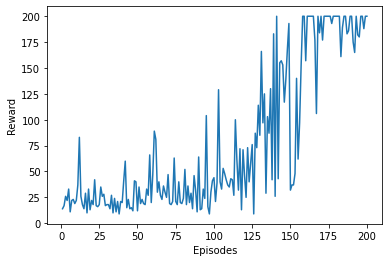

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

filename = 'Cartpole.png'
x = [i+1 for i in range(n_games)]

# plot_learning_curve(x,scores,eps_history,filename)

# x = [i+1 for i in range(n_games)]

# plotLearning(x,scores,eps_history,filename)
plt.plot(x, scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()
plt.savefig('saved_figure.png')

* It took around 140-150 episodes to continuously get the highest reward
* The above code uses same network for both estimating the target and the action (like chasing its own tail).
* Next, write code with two different networks one for estimating target and other to choose action